In [2]:
import librosa.display
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import soundfile as sf
from scipy.signal import butter, filtfilt

In [8]:
# 指定存放 WAV 檔案的根目錄
wav_directory = "correlation_wav"

def normalize_audio(wav):
    # 標準化音頻信號
    return wav / np.max(np.abs(wav))

def loudness_normalize_audio(wav, target_dB=-20.0):
    # 計算信號的RMS
    rms = np.sqrt(np.mean(np.square(wav)))
    # 計算響度校正因子
    scalar = 10 ** (target_dB / 20) / rms
    return wav * scalar

def amplify_audio(wav, factor):
    # 放大音頻信號
    return wav * factor

def trim_audio(wav, sr, trim_duration=0.5):
    # 移除前後 trim_duration 秒
    trim_samples = int(trim_duration * sr)
    if len(wav) > 2 * trim_samples:
        return wav[trim_samples:-trim_samples]
    else:
        return wav  # 如果音頻長度不足以移除前後 trim_duration 秒，則不進行裁剪

def hamming_window(y):
    window = np.hamming(len(y))
    wav = y * window
    return wav
    
def load_wav_files(directory, target_sr=44100, amplification_factor=80, trim_duration=1):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        with tqdm(total=len(files), desc='Loading files', unit='file') as pbar:
            for file in files:
                if file.endswith(".wav") and file != 'all_channel.wav':
                    file_path = os.path.join(root, file)
                    y, sr = librosa.load(file_path, sr=None)
                    if sr != target_sr:
                        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
                    
                    y = trim_audio(y, sr=target_sr)
                    y = loudness_normalize_audio(y)
                    y = amplify_audio(y, amplification_factor)

                    # remove wav_directory from root
                    path = root.split(os.path.sep)
                    filename = f'{path[1]}_{file}'
                    pbar.set_postfix(file=filename,)
                    wav_files.append((y, filename))
                pbar.update(1)
    return wav_files

In [14]:
# 載入音頻檔案
wav_files = load_wav_files(wav_directory, target_sr=44100)

Loading files: 0file [00:00, ?file/s]
Loading files: 100%|██████████| 1/1 [00:00<00:00,  1.87file/s, file=normal-34A-12-10-2_Mic000.wav]


In [15]:
def correlation_matrix(wav_files, n_fft=512, hop_length=256):
    # 計算音頻信號的 STFT
    stfts = []
    for y, filename in wav_files:
        y = hamming_window(y)
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        stfts.append((D, filename))

    # 計算音頻信號的相關矩陣
    correlation_matrices = []
    for i in range(len(stfts)):
        D1, filename1 = stfts[i]
        for j in range(i + 1, len(stfts)):
            D2, filename2 = stfts[j]
            correlation_matrix = np.abs(np.dot(D1.T, D2))
            correlation_matrices.append((correlation_matrix, filename1, filename2))
    return correlation_matrices

def plot_correlation_matrix(correlation_matrices, target_sr=44100, hop_length=256):
    # 繪製相關矩陣
    for correlation_matrix, filename1, filename2 in correlation_matrices:
        plt.figure(figsize=(10, 10))
        librosa.display.specshow(librosa.amplitude_to_db(correlation_matrix, ref=np.max), y_axis='log', x_axis='time', hop_length=hop_length, sr=target_sr)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Correlation Matrix of {filename1} and {filename2}')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png')
        plt.show()

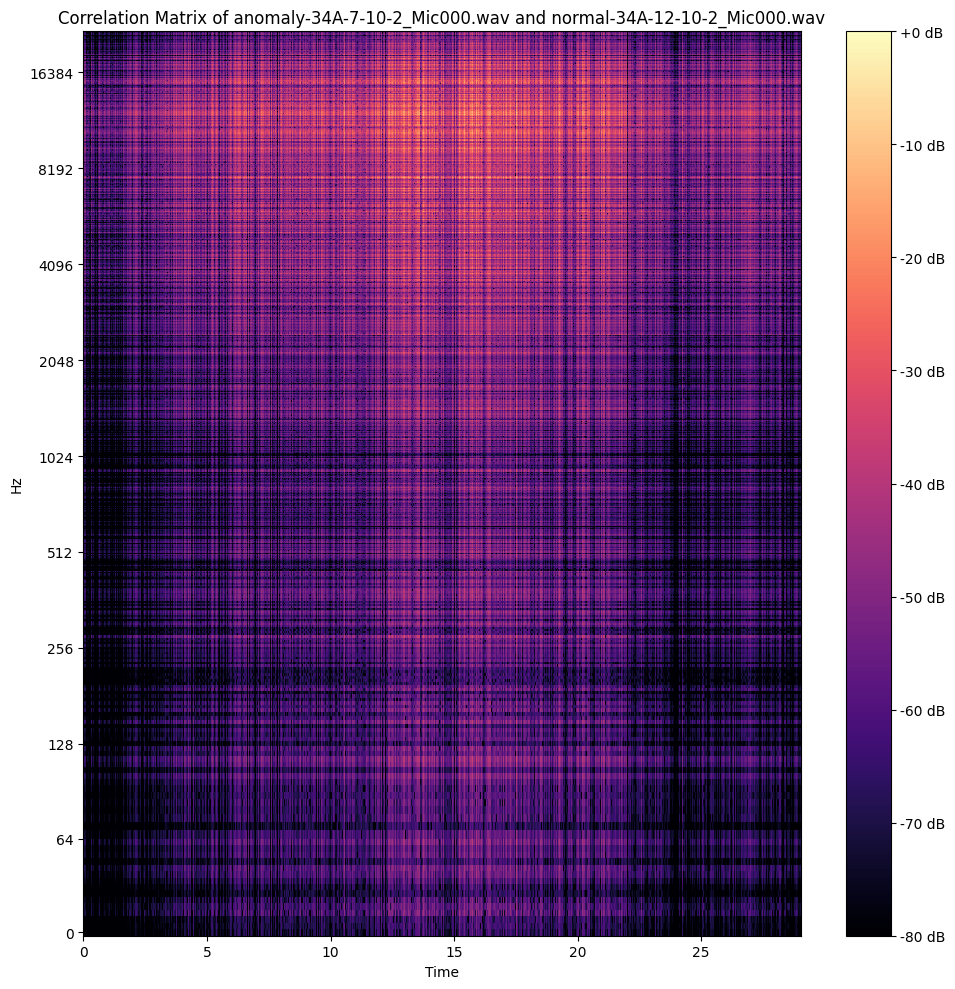

In [16]:
# 計算相關矩陣
correlation_matrices = correlation_matrix(wav_files)
# 繪製相關矩陣
plot_correlation_matrix(correlation_matrices)

In [81]:
def plot_mel_spectrogram(y, sr=16000, n_fft=512, hop_length=256):
    # 繪製梅爾頻譜圖
    S = hamming_window(y)
    S = librosa.feature.melspectrogram(S, sr=sr, n_fft=n_fft, hop_length=hop_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
    
def plot_stft(y, sr=16000, n_fft=512, hop_length=256):
    # 繪製短時傅立葉變換 (STFT)
# 計算短時傅立葉變換 (STFT)
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # 繪製頻譜圖
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram of Wind Turbine Blade Noise')
    plt.show()
    
def plot_mfcc(y, sr=16000, n_fft=512, hop_length=256, n_mfcc=13):
    # 繪製 MFCC
    mfccs = librosa.feature.mfcc(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=hop_length)
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()
    
def plot_waveform(y, sr=16000):
    # 繪製波形圖
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.tight_layout()
    plt.show()
    
def plot_spectrogram(y, sr=16000, n_fft=512, hop_length=256):
    # 繪製頻譜圖
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()
    
def plot_cwt(y, sr=16000, n_fft=512, hop_length=256):
    # 設定小波變換參數
    scales = np.arange(1, 256)
    wavelet = 'cmor1.5-1.0'
    
    # 計算連續小波變換 (CWT)
    coefficients, frequencies = pywt.cwt(y, scales, wavelet, sampling_period=1/sr)
    
    # 繪製小波變換圖
    plt.figure(figsize=(12, 6))
    plt.imshow(np.abs(coefficients), extent=[0, len(y) / sr, scales[-1], scales[0]], cmap='PRGn', aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
    plt.colorbar(label='Magnitude')
    plt.title('Continuous Wavelet Transform of Wind Turbine Blade Noise')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Scale')
    plt.show()
    
    
def plot_harmonic(y, sr=16000, n_fft=512, hop_length=256):
    # 繪製諧波
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.5, label='Harmonic')
    librosa.display.waveshow(y_percussive, sr=sr, color='r', alpha=0.5, label='Percussive')
    plt.title('Harmonic and Percussive')
    plt.tight_layout()
    plt.show()
    
from scipy.signal import welch
def plot_psd(y, sr=16000, n_fft=512, hop_length=256):
    # 計算功率頻譜密度 (PSD)
    frequencies, psd = welch(y, fs=sr, nperseg=1024)
    
    # 繪製 PSD 圖
    plt.figure(figsize=(10, 6))
    plt.semilogy(frequencies, psd)
    plt.title('Power Spectral Density (PSD) of Wind Turbine Blade Noise')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(True)
    plt.show()
    
def plot_correlation(input_signal1, input_signal2, sample_rate=16000):
    # 計算自相關
    autocorr = np.correlate(input_signal1, input_signal2, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    norm_autocorr = autocorr / np.max(autocorr)
    # 計算滯後時間軸
    lags = np.arange(autocorr.size) / sample_rate
    
    # 繪製自相關圖
    plt.figure(figsize=(10, 6))
    plt.plot(lags, norm_autocorr)
    plt.title('Autocorrelation of Wind Turbine Blade Noise')
    plt.xlabel('Lag (seconds)')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

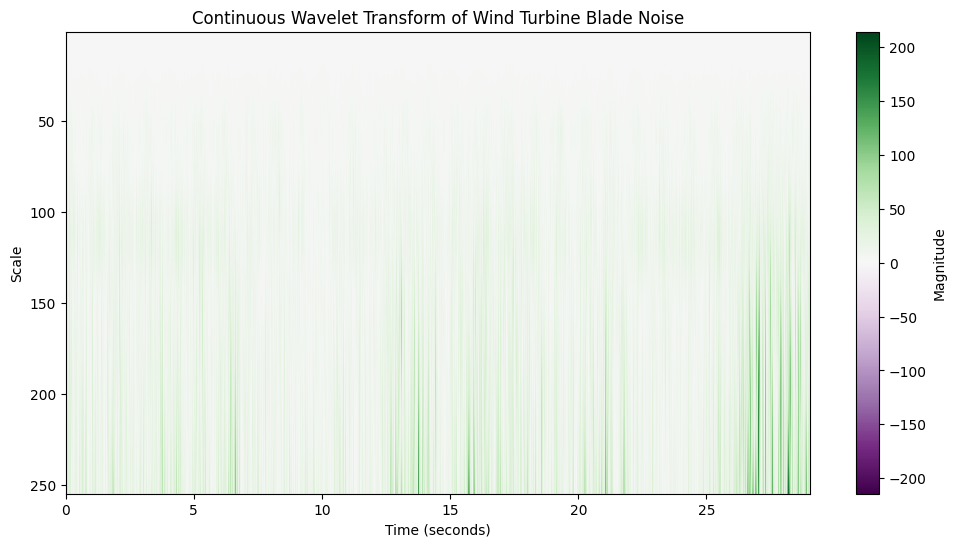

In [82]:
plot_cwt(wav_files[0][0])

C:\Users\snick\AppData\Local\Temp\ipykernel_14704\2920304644.py:4: FutureWarning: Pass y=[1.16818398 1.11351074 1.08814621 ... 0.16025183 0.14127046 0.14354797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(S, sr=sr, n_fft=n_fft, hop_length=hop_length)


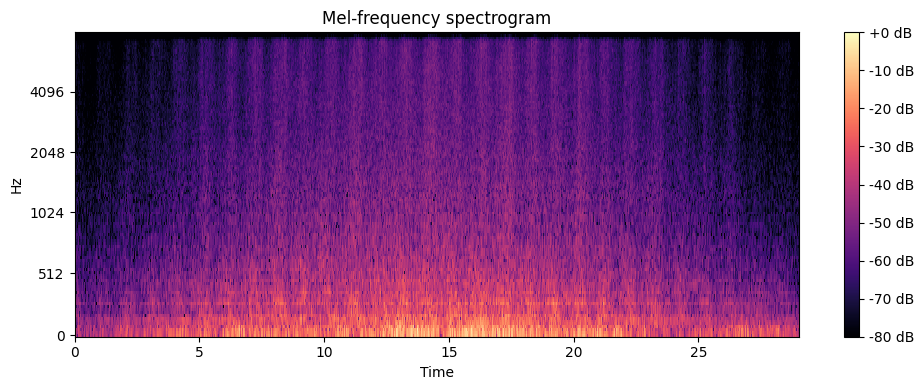

C:\Users\snick\AppData\Local\Temp\ipykernel_14704\2920304644.py:4: FutureWarning: Pass y=[-0.8208815  -0.79638016 -0.75787453 ... -0.75258469 -0.73448685
 -0.69521957] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(S, sr=sr, n_fft=n_fft, hop_length=hop_length)


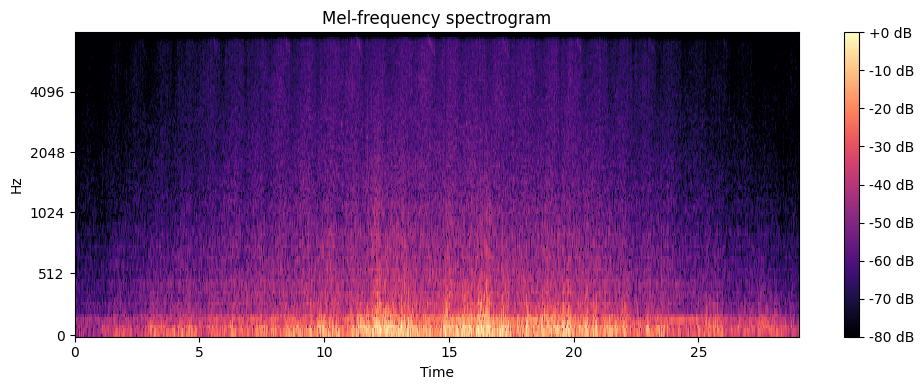

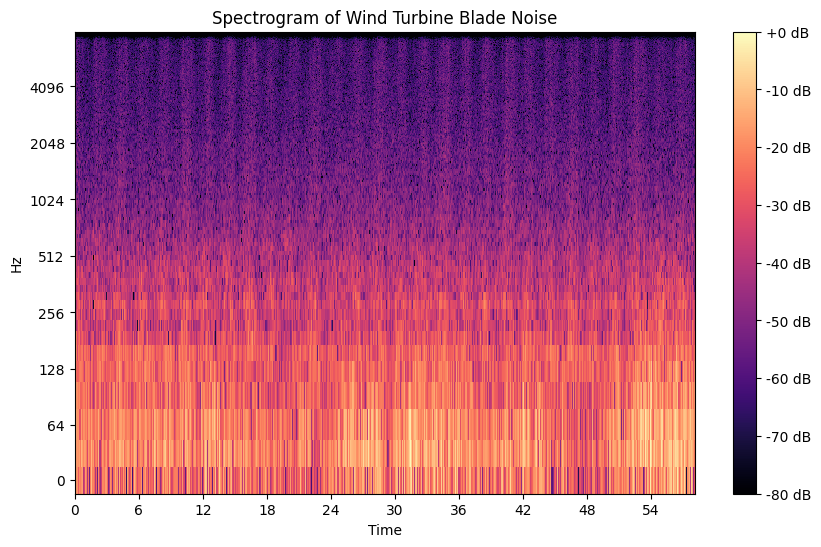

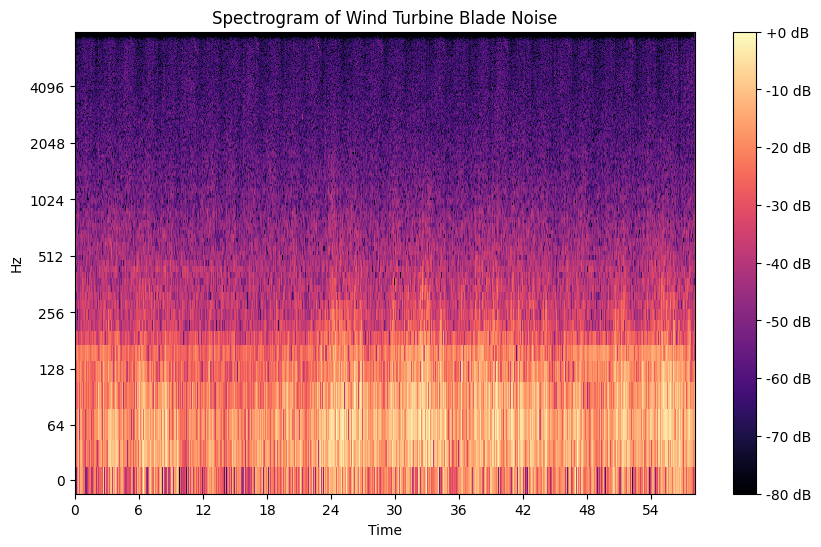

In [83]:
plot_mel_spectrogram(wav_files[0][0])
plot_mel_spectrogram(wav_files[1][0])
plot_stft(wav_files[0][0])
plot_stft(wav_files[1][0])

C:\Users\snick\AppData\Local\Temp\ipykernel_14704\2920304644.py:27: FutureWarning: Pass y=[14.6023    13.918884  13.601828  ...  2.0031478  1.7658807  1.7943497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)


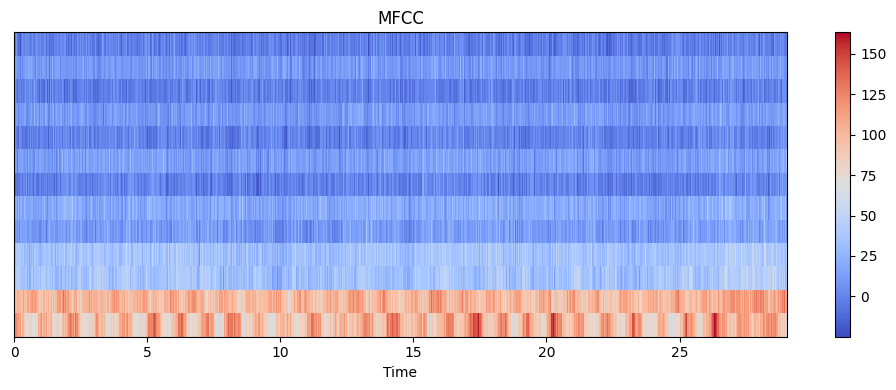

In [84]:
plot_mfcc(wav_files[0][0])

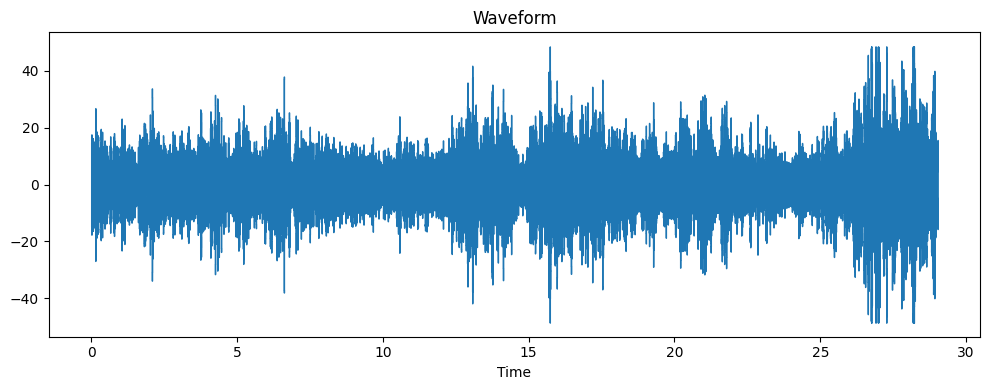

In [85]:
plot_waveform(wav_files[0][0])

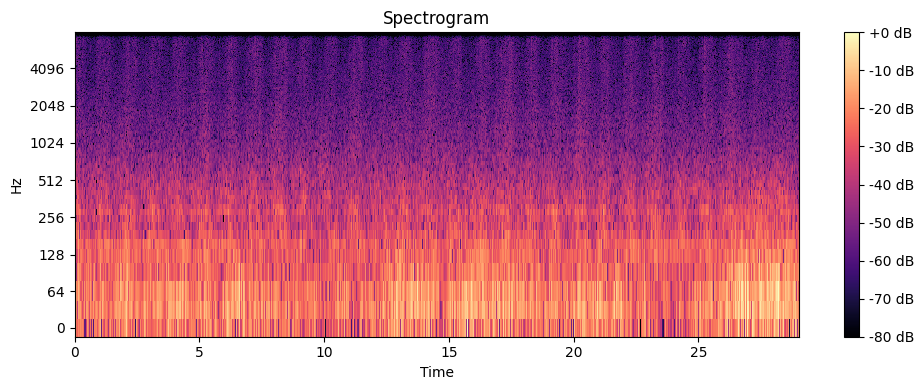

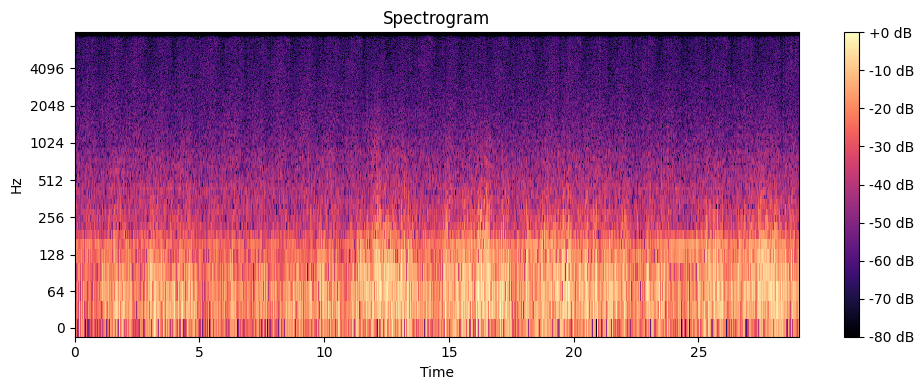

In [86]:
plot_spectrogram(wav_files[0][0])
plot_spectrogram(wav_files[1][0])

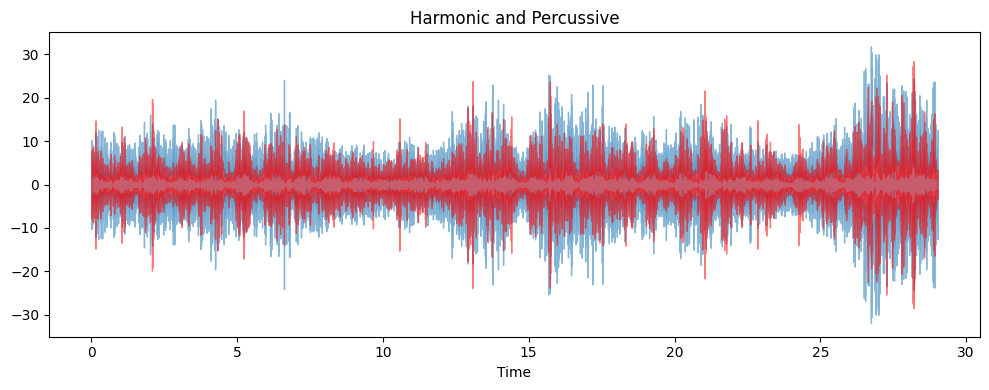

In [87]:
plot_harmonic(wav_files[0][0])

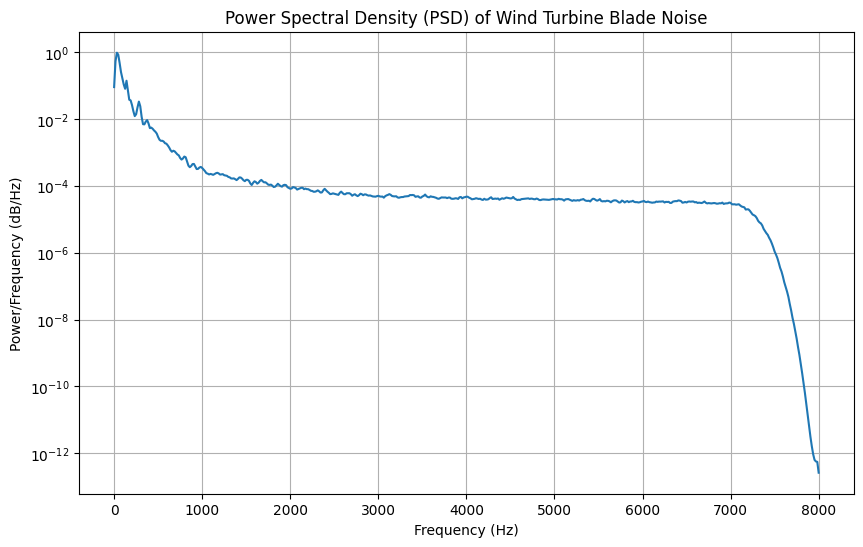

In [88]:
plot_psd(wav_files[0][0])

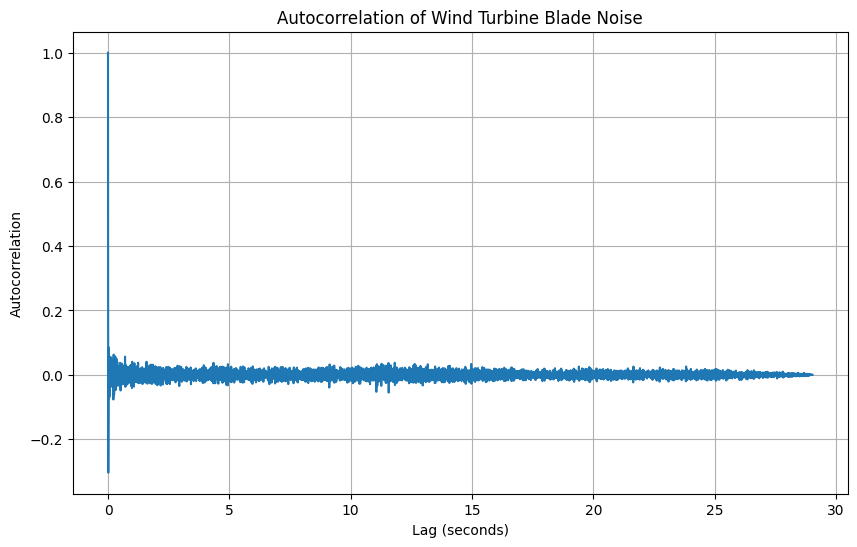

In [89]:
plot_correlation(wav_files[0][0], wav_files[0][0])

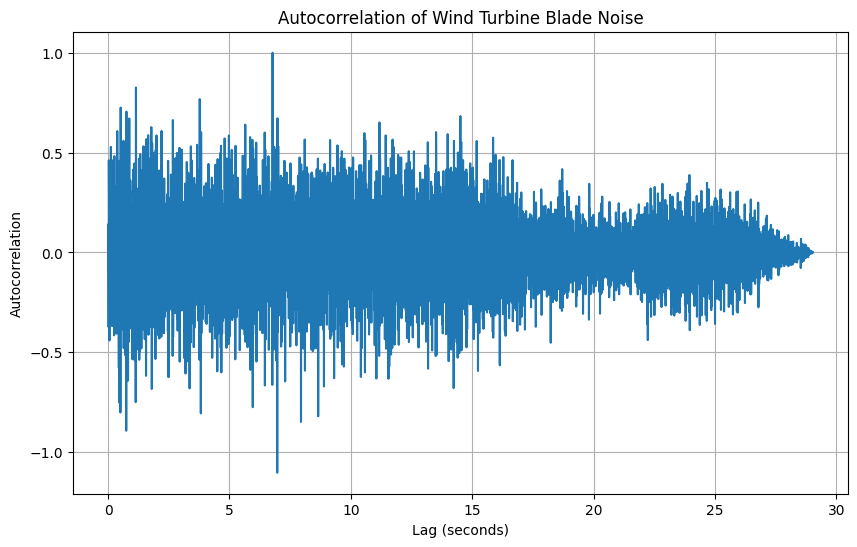

In [90]:
plot_correlation(wav_files[0][0], wav_files[1][0])

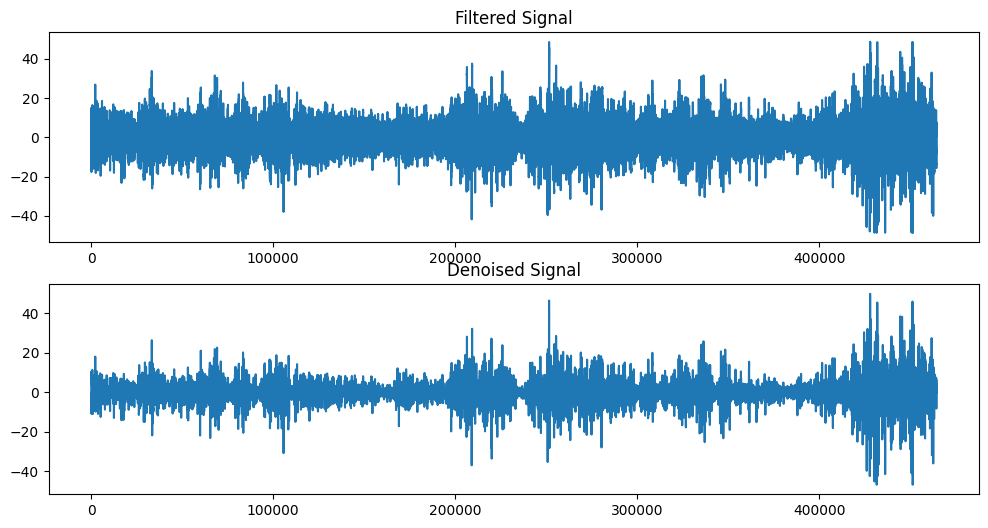

In [91]:
def wavelet_denoise(data, wavelet='db8', level=4):
    coeff = pywt.wavedec(data, wavelet, mode='per')
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

# 小波去噪後的信號
denoised_signal = wavelet_denoise(wav_files[0][0])

# 繪製濾波後的信號和去噪後的信號
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(wav_files[0][0])
plt.title('Filtered Signal')
plt.subplot(2, 1, 2)
plt.plot(denoised_signal)
plt.title('Denoised Signal')
plt.show()

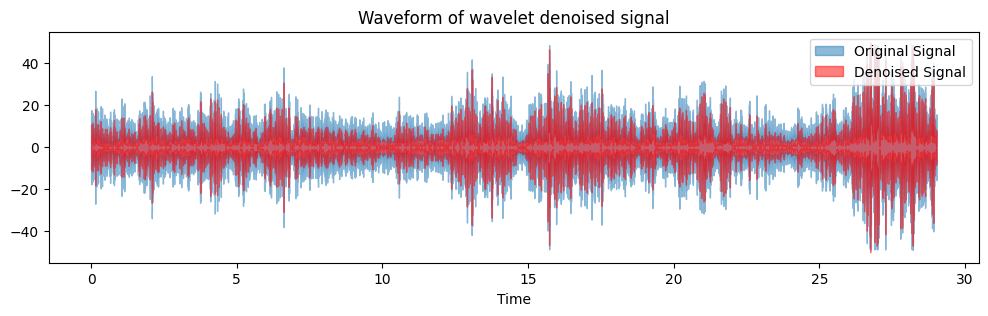

In [105]:
import librosa.display as display
plt.figure(figsize=(12, 3))
plt.title('Waveform of wavelet denoised signal')
# play the original signal
display.waveshow(wav_files[0][0], sr=16000, alpha=0.5, label='Original Signal')
# play the denoised signal
display.waveshow(denoised_signal, sr=16000, color='r', alpha=0.5, label='Denoised Signal')
plt.legend()
plt.show()

In [93]:
from IPython.lib.display import Audio
# play the original signal
Audio(wav_files[0][0], rate=16000)

In [94]:
# play the denoised signal
Audio(denoised_signal, rate=16000)

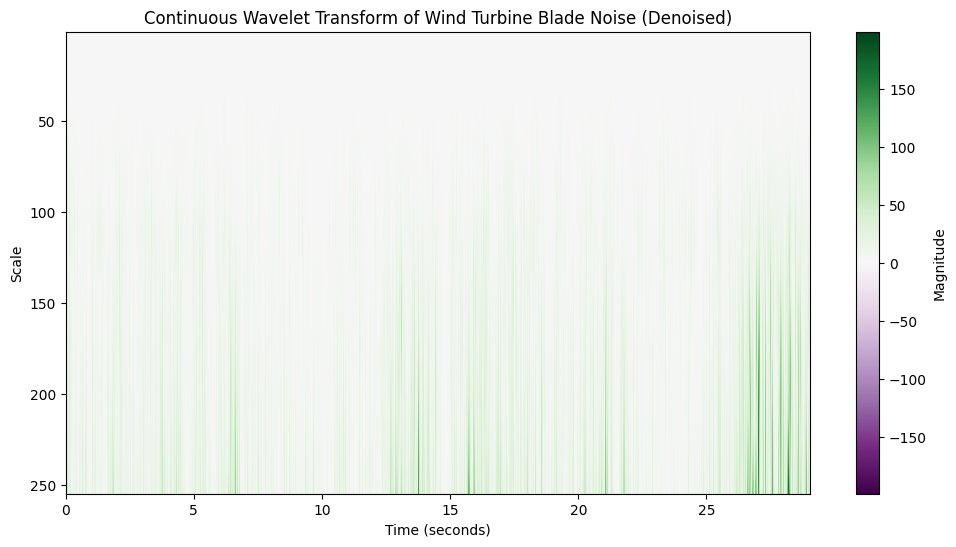

In [106]:
wavelet = 'cmor1.5-1.0'
scales = np.arange(1, 256)
# 計算連續小波變換 (CWT)
coefficients, frequencies = pywt.cwt(denoised_signal, scales, wavelet, sampling_period=1/16000)

# 繪製小波變換圖
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coefficients), extent=[0, len(denoised_signal) / 16000, scales[-1], scales[0]], cmap='PRGn', aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform of Wind Turbine Blade Noise (Denoised)')
plt.xlabel('Time (seconds)')
plt.ylabel('Scale')
plt.show()